https://github.com/EthicalSecurity-Agency/CyberBattleSim-CyberBattleSim/blob/main/notebooks/chainnetwork-optionwrapper.ipynb
https://github.com/EthicalSecurity-Agency/CyberBattleSim-CyberBattleSim/blob/main/notebooks/notebook_benchmark-toyctf.ipynb

In [1]:
import sys
import logging
from typing import cast
import gym
import numpy as np
import matplotlib.pyplot as plt  # type:ignore
from cyberbattle.agents.baseline.learner import TrainedLearner
import cyberbattle.agents.baseline.plotting as p
import cyberbattle.agents.baseline.agent_wrapper as w
import cyberbattle.agents.baseline.agent_tabularqlearning as a
from cyberbattle.agents.baseline.agent_wrapper import Verbosity
import cyberbattle.agents.baseline.learner as learner
import importlib
import cyberbattle.agents.baseline.agent_dql as dqla
import cyberbattle.agents.baseline.agent_randomcredlookup as rca
import cyberbattle.agents.baseline.agent_ppo as ppo
from cyberbattle._env.defender import ScanAndReimageCompromisedMachines
from cyberbattle._env.cyberbattle_env import AttackerGoal, DefenderConstraint
from typing import cast
from cyberbattle._env.cyberbattle_env import CyberBattleEnv
from cyberbattle._env.cyberbattle_toyctf import CyberBattleToyCtf
from stable_baselines3.a2c.a2c import A2C
from stable_baselines3.ppo.ppo import PPO
from cyberbattle._env.flatten_wrapper import FlattenObservationWrapper, FlattenActionWrapper
import os
from stable_baselines3 import PPO
logging.basicConfig(stream=sys.stdout, level=logging.ERROR, format="%(levelname)s: %(message)s")

In [2]:
import random
random.seed(120394016)
%matplotlib inline

In [3]:
importlib.reload(learner)
importlib.reload(p)
importlib.reload(p)

<module 'cyberbattle.agents.baseline.plotting' from '/home/gmod1/CyberBattleSim/cyberbattle/agents/baseline/plotting.py'>

In [4]:
# setting up environment
#cyberbattlechain_defender = gym.make('CyberBattleChain-v0',
#                                     size=10,
#                                     attacker_goal=AttackerGoal(
#                                         own_atleast=0,
#                                         own_atleast_percent=1.0
#                                     ),
#                                     defender_constraint=DefenderConstraint(
#                                         maintain_sla=0.80
#                                     ),
#                                     defender_agent=ScanAndReimageCompromisedMachines(
#                                         probability=0.6,
#                                         scan_capacity=2,
#                                         scan_frequency=5))

In [37]:
import gym
from cyberbattle._env.cyberbattle_env import AttackerGoal, DefenderConstraint
from cyberbattle._env.defender import ScanAndReimageCompromisedMachines

#parameters for "CyberBattleToyCtf-v0"
maximum_node_count = 12
maximum_total_credentials = 10
iteration_count = 1500
training_episode_count = 20
eval_episode_count = 10

#create the CyberBattleToyCtf environment
cyberbattlechain_defender = gym.make("CyberBattleToyCtf-v0",
                                  maximum_node_count=maximum_node_count,
                                  maximum_total_credentials=maximum_total_credentials,
                                  attacker_goal=AttackerGoal(
                                      own_atleast=0,
                                      own_atleast_percent=1.0
                                  ),
                                  defender_constraint=DefenderConstraint(
                                      maintain_sla=0.80
                                  ),
                                  defender_agent=ScanAndReimageCompromisedMachines(
                                      probability=0.6,
                                      scan_capacity=2,
                                      scan_frequency=5))



In [6]:
cyberbattlechain_defender.environment

Environment(network=<networkx.classes.digraph.DiGraph object at 0x7efbae3a7160>, vulnerability_library={}, identifiers=Identifiers(properties=['CTFFLAG:LeakedCustomerData', 'CTFFLAG:LeakedCustomerData2', 'CTFFLAG:Readme.txt-Discover secret data', 'CTFFLAG:VMPRIVATEINFO', 'GitHub', 'MySql', 'SasUrlInCommit', 'SharepointLeakingPassword', 'Ubuntu', 'nginx/1.10.3'], ports=['GIT', 'HTTPS', 'MySQL', 'PING', 'SSH', 'SSH-key', 'su'], local_vulnerabilities=['CredScan-HomeDirectory', 'CredScanBashHistory', 'SearchEdgeHistory'], remote_vulnerabilities=['AccessDataWithSASToken', 'CredScanGitHistory', 'ListAzureResources', 'NavigateWebDirectory', 'NavigateWebDirectoryFurther', 'ScanPageContent', 'ScanPageSource', 'ScanSharepointParentDirectory']), creationTime=datetime.datetime(2024, 1, 11, 17, 50, 0, 175361), lastModified=datetime.datetime(2024, 1, 11, 17, 50, 0, 175363), version='0.1.0')

In [7]:
cyberbattlechain_defender.environment.network.nodes

NodeView(('Website', 'Website.Directory', 'Website[user=monitor]', 'GitHubProject', 'AzureStorage', 'Sharepoint', 'AzureResourceManager', 'AzureResourceManager[user=monitor]', 'AzureVM', 'client'))

In [8]:
cyberbattlechain_defender.action_space

DiscriminatedUnion(connect:MultiDiscrete([12 12  7 10]), local_vulnerability:MultiDiscrete([12  3]), remote_vulnerability:MultiDiscrete([12 12  8]))

In [9]:
cyberbattlechain_defender.observation_space

Dict(_credential_cache:<cyberbattle._env.cyberbattle_env.DummySpace object at 0x7efbae3c0580>, _discovered_nodes:<cyberbattle._env.cyberbattle_env.DummySpace object at 0x7efbae3c05e0>, _explored_network:<cyberbattle._env.cyberbattle_env.DummySpace object at 0x7efbae3c06a0>, action_mask:Dict(connect:MultiBinary([12, 12, 7, 10]), local_vulnerability:MultiBinary([12, 3]), remote_vulnerability:MultiBinary([12, 12, 8])), credential_cache_length:Discrete(10), credential_cache_matrix:Tuple(MultiDiscrete([12  7]), MultiDiscrete([12  7]), MultiDiscrete([12  7]), MultiDiscrete([12  7]), MultiDiscrete([12  7]), MultiDiscrete([12  7]), MultiDiscrete([12  7]), MultiDiscrete([12  7]), MultiDiscrete([12  7]), MultiDiscrete([12  7])), customer_data_found:MultiBinary(1), discovered_node_count:Discrete(12), discovered_nodes_properties:Tuple(MultiDiscrete([3 3 3 3 3 3 3 3 3 3]), MultiDiscrete([3 3 3 3 3 3 3 3 3 3]), MultiDiscrete([3 3 3 3 3 3 3 3 3 3]), MultiDiscrete([3 3 3 3 3 3 3 3 3 3]), MultiDiscrete

In [10]:
cyberbattlechain_defender.observation_space['action_mask']

Dict(connect:MultiBinary([12, 12, 7, 10]), local_vulnerability:MultiBinary([12, 3]), remote_vulnerability:MultiBinary([12, 12, 8]))

In [11]:
cyberbattlechain_defender.action_space.sample()

OrderedDict([('local_vulnerability', array([4, 2]))])

In [12]:
cyberbattlechain_defender.observation_space.sample()

OrderedDict([('_credential_cache',
              [CachedCredential(node='Sharepoint', port='HTTPS', credential='ADPrincipalCreds')]),
             ('_discovered_nodes', ['node1', 'node0', 'node2']),
             ('_explored_network',
              <networkx.classes.digraph.DiGraph at 0x7efbae3c0640>),
             ('action_mask',
              OrderedDict([('connect',
                            array([[[[0, 1, 1, ..., 0, 1, 1],
                                     [0, 1, 1, ..., 0, 0, 0],
                                     [0, 0, 0, ..., 0, 1, 0],
                                     ...,
                                     [1, 0, 1, ..., 0, 1, 0],
                                     [0, 1, 0, ..., 0, 1, 0],
                                     [1, 0, 0, ..., 1, 0, 1]],
                            
                                    [[1, 1, 1, ..., 1, 1, 0],
                                     [1, 0, 1, ..., 1, 1, 1],
                                     [0, 1, 0, ..., 0, 1, 1],

In [13]:
random.seed(120394016)
for i_episode in range(1):
    observation = cyberbattlechain_defender.reset()

    total_reward = 0

    for t in range(5600):
        action = cyberbattlechain_defender.sample_valid_action()

        observation, reward, done, info = cyberbattlechain_defender.step(action)
        
        total_reward += reward
        
        if reward>0:
            print('####### rewarded action: {action}')
            print(f'total_reward={total_reward} reward={reward}')
            cyberbattlechain_defender.render()
    
        if done:
            print("Episode finished after {} timesteps".format(t+1))
            break

    cyberbattlechain_defender.render()

cyberbattlechain_defender.close()
print("simulation ended")

####### rewarded action: {action}
total_reward=11.0 reward=11.0


status properties        local_attacks  \
id                                                    
client        owned         []  [SearchEdgeHistory]   
Website  discovered        NaN                 None   

                            remote_attacks  
id                                          
client                                  []  
Website  [ScanPageContent, ScanPageSource]

####### rewarded action: {action}
total_reward=22.0 reward=11.0


status properties        local_attacks  \
id                                                          
client              owned         []  [SearchEdgeHistory]   
Website        discovered        NaN                 None   
GitHubProject  discovered        NaN                 None   

                                  remote_attacks  
id                                                
client                                        []  
Website        [ScanPageContent, ScanPageSource]  
GitHubProject               [CredScanGitHistory]

####### rewarded action: {action}
total_reward=33.0 reward=11.0


status properties        local_attacks  \
id                                                              
client                  owned         []  [SearchEdgeHistory]   
Website            discovered        NaN                 None   
GitHubProject      discovered        NaN                 None   
Website.Directory  discovered        NaN                 None   

                                                      remote_attacks  
id                                                                    
client                                                            []  
Website                            [ScanPageContent, ScanPageSource]  
GitHubProject                                   [CredScanGitHistory]  
Website.Directory  [NavigateWebDirectoryFurther, NavigateWebDirec...

####### rewarded action: {action}
total_reward=44.0 reward=11.0


status properties        local_attacks  \
id                                                              
client                  owned         []  [SearchEdgeHistory]   
Website            discovered        NaN                 None   
GitHubProject      discovered        NaN                 None   
Website.Directory  discovered        NaN                 None   
Sharepoint         discovered        NaN                 None   

                                                      remote_attacks  
id                                                                    
client                                                            []  
Website                            [ScanPageContent, ScanPageSource]  
GitHubProject                                   [CredScanGitHistory]  
Website.Directory  [NavigateWebDirectoryFurther, NavigateWebDirec...  
Sharepoint                           [ScanSharepointParentDirectory]

####### rewarded action: {action}
total_reward=58.0 reward=14.0


status properties        local_attacks  \
id                                                                 
client                     owned         []  [SearchEdgeHistory]   
Website               discovered        NaN                 None   
GitHubProject         discovered        NaN                 None   
Website.Directory     discovered        NaN                 None   
Sharepoint            discovered        NaN                 None   
AzureResourceManager  discovered        NaN                 None   

                                                         remote_attacks  
id                                                                       
client                                                               []  
Website                               [ScanPageContent, ScanPageSource]  
GitHubProject                                      [CredScanGitHistory]  
Website.Directory     [NavigateWebDirectoryFurther, NavigateWebDirec...  
Sharepoint                              [ScanSharepointParentDirectory]  
AzureResourceManager                               [ListAzureResources]

####### rewarded action: {action}
total_reward=72.0 reward=14.0


status properties        local_attacks  \
id                                                                 
client                     owned         []  [SearchEdgeHistory]   
Website               discovered        NaN                 None   
GitHubProject         discovered        NaN                 None   
Website.Directory     discovered        NaN                 None   
Sharepoint            discovered        NaN                 None   
AzureResourceManager  discovered        NaN                 None   
AzureStorage          discovered        NaN                 None   

                                                         remote_attacks  
id                                                                       
client                                                               []  
Website                               [ScanPageContent, ScanPageSource]  
GitHubProject                                      [CredScanGitHistory]  
Website.Directory     [NavigateWebDirectoryFurther, NavigateWebDirec...  
Sharepoint                              [ScanSharepointParentDirectory]  
AzureResourceManager                               [ListAzureResources]  
AzureStorage                                   [AccessDataWithSASToken]

####### rewarded action: {action}
total_reward=83.0 reward=11.0


status properties        local_attacks  \
id                                                                 
client                     owned         []  [SearchEdgeHistory]   
Website               discovered        NaN                 None   
GitHubProject         discovered        NaN                 None   
Website.Directory     discovered        NaN                 None   
Sharepoint            discovered        NaN                 None   
AzureResourceManager  discovered        NaN                 None   
AzureStorage          discovered        NaN                 None   
AzureVM               discovered        NaN                 None   

                                                         remote_attacks  
id                                                                       
client                                                               []  
Website                               [ScanPageContent, ScanPageSource]  
GitHubProject                                      [CredScanGitHistory]  
Website.Directory     [NavigateWebDirectoryFurther, NavigateWebDirec...  
Sharepoint                              [ScanSharepointParentDirectory]  
AzureResourceManager                               [ListAzureResources]  
AzureStorage                                   [AccessDataWithSASToken]  
AzureVM                                                              []

####### rewarded action: {action}
total_reward=92.0 reward=9.0


status properties        local_attacks  \
id                                                                 
client                     owned         []  [SearchEdgeHistory]   
Website               discovered        NaN                 None   
GitHubProject         discovered        NaN                 None   
Website.Directory     discovered        NaN                 None   
Sharepoint            discovered        NaN                 None   
AzureResourceManager  discovered        NaN                 None   
AzureStorage          discovered        NaN                 None   
AzureVM               discovered        NaN                 None   

                                                         remote_attacks  
id                                                                       
client                                                               []  
Website                               [ScanPageContent, ScanPageSource]  
GitHubProject                                      [CredScanGitHistory]  
Website.Directory     [NavigateWebDirectoryFurther, NavigateWebDirec...  
Sharepoint                              [ScanSharepointParentDirectory]  
AzureResourceManager                               [ListAzureResources]  
AzureStorage                                   [AccessDataWithSASToken]  
AzureVM                                                              []

####### rewarded action: {action}
total_reward=142.0 reward=50.0


status                    properties  \
id                                                               
client                     owned                            []   
AzureStorage               owned  [CTFFLAG:LeakedCustomerData]   
Website               discovered                           NaN   
GitHubProject         discovered                           NaN   
Website.Directory     discovered                           NaN   
Sharepoint            discovered                           NaN   
AzureResourceManager  discovered                           NaN   
AzureVM               discovered                           NaN   

                            local_attacks  \
id                                          
client                [SearchEdgeHistory]   
AzureStorage                           []   
Website                              None   
GitHubProject                        None   
Website.Directory                    None   
Sharepoint                           None   
AzureResourceManager                 None   
AzureVM                              None   

                                                         remote_attacks  
id                                                                       
client                                                               []  
AzureStorage                                   [AccessDataWithSASToken]  
Website                               [ScanPageContent, ScanPageSource]  
GitHubProject                                      [CredScanGitHistory]  
Website.Directory     [NavigateWebDirectoryFurther, NavigateWebDirec...  
Sharepoint                              [ScanSharepointParentDirectory]  
AzureResourceManager                               [ListAzureResources]  
AzureVM                                                              []

####### rewarded action: {action}
total_reward=148.0 reward=6.0


status properties        local_attacks  \
id                                                                 
client                     owned         []  [SearchEdgeHistory]   
Website               discovered        NaN                 None   
GitHubProject         discovered        NaN                 None   
Website.Directory     discovered        NaN                 None   
Sharepoint            discovered        NaN                 None   
AzureResourceManager  discovered        NaN                 None   
AzureStorage          discovered        NaN                 None   
AzureVM               discovered        NaN                 None   

                                                         remote_attacks  
id                                                                       
client                                                               []  
Website                               [ScanPageContent, ScanPageSource]  
GitHubProject                                      [CredScanGitHistory]  
Website.Directory     [NavigateWebDirectoryFurther, NavigateWebDirec...  
Sharepoint                              [ScanSharepointParentDirectory]  
AzureResourceManager                               [ListAzureResources]  
AzureStorage                                   [AccessDataWithSASToken]  
AzureVM                                                              []

####### rewarded action: {action}
total_reward=248.0 reward=100.0


status                     properties  \
id                                                                
client                     owned                             []   
Website                    owned  [MySql, Ubuntu, nginx/1.10.3]   
GitHubProject         discovered                            NaN   
Website.Directory     discovered                            NaN   
Sharepoint            discovered                            NaN   
AzureResourceManager  discovered                            NaN   
AzureStorage          discovered                            NaN   
AzureVM               discovered                            NaN   

                              local_attacks  \
id                                            
client                  [SearchEdgeHistory]   
Website               [CredScanBashHistory]   
GitHubProject                          None   
Website.Directory                      None   
Sharepoint                             None   
AzureResourceManager                   None   
AzureStorage                           None   
AzureVM                                None   

                                                         remote_attacks  
id                                                                       
client                                                               []  
Website                               [ScanPageContent, ScanPageSource]  
GitHubProject                                      [CredScanGitHistory]  
Website.Directory     [NavigateWebDirectoryFurther, NavigateWebDirec...  
Sharepoint                              [ScanSharepointParentDirectory]  
AzureResourceManager                               [ListAzureResources]  
AzureStorage                                   [AccessDataWithSASToken]  
AzureVM                                                              []

####### rewarded action: {action}
total_reward=262.0 reward=14.0


status                     properties  \
id                                                                 
client                      owned                             []   
Website                     owned  [MySql, Ubuntu, nginx/1.10.3]   
GitHubProject          discovered                            NaN   
Website.Directory      discovered                            NaN   
Sharepoint             discovered                            NaN   
AzureResourceManager   discovered                            NaN   
AzureStorage           discovered                            NaN   
AzureVM                discovered                            NaN   
Website[user=monitor]  discovered                            NaN   

                               local_attacks  \
id                                             
client                   [SearchEdgeHistory]   
Website                [CredScanBashHistory]   
GitHubProject                           None   
Website.Directory                       None   
Sharepoint                              None   
AzureResourceManager                    None   
AzureStorage                            None   
AzureVM                                 None   
Website[user=monitor]                   None   

                                                          remote_attacks  
id                                                                        
client                                                                []  
Website                                [ScanPageContent, ScanPageSource]  
GitHubProject                                       [CredScanGitHistory]  
Website.Directory      [NavigateWebDirectoryFurther, NavigateWebDirec...  
Sharepoint                               [ScanSharepointParentDirectory]  
AzureResourceManager                                [ListAzureResources]  
AzureStorage                                    [AccessDataWithSASToken]  
AzureVM                                                               []  
Website[user=monitor]                                                 []

####### rewarded action: {action}
total_reward=312.0 reward=50.0


status                     properties  \
id                                                                 
client                      owned                             []   
AzureResourceManager        owned  [CTFFLAG:LeakedCustomerData2]   
Website                discovered                            NaN   
GitHubProject          discovered                            NaN   
Website.Directory      discovered                            NaN   
Sharepoint             discovered                            NaN   
AzureStorage           discovered                            NaN   
AzureVM                discovered                            NaN   
Website[user=monitor]  discovered                            NaN   

                             local_attacks  \
id                                           
client                 [SearchEdgeHistory]   
AzureResourceManager                    []   
Website                               None   
GitHubProject                         None   
Website.Directory                     None   
Sharepoint                            None   
AzureStorage                          None   
AzureVM                               None   
Website[user=monitor]                 None   

                                                          remote_attacks  
id                                                                        
client                                                                []  
AzureResourceManager                                [ListAzureResources]  
Website                                [ScanPageContent, ScanPageSource]  
GitHubProject                                       [CredScanGitHistory]  
Website.Directory      [NavigateWebDirectoryFurther, NavigateWebDirec...  
Sharepoint                               [ScanSharepointParentDirectory]  
AzureStorage                                    [AccessDataWithSASToken]  
AzureVM                                                               []  
Website[user=monitor]                                                 []

status properties        local_attacks  \
id                                                                  
client                      owned         []  [SearchEdgeHistory]   
Website                discovered        NaN                 None   
GitHubProject          discovered        NaN                 None   
Website.Directory      discovered        NaN                 None   
Sharepoint             discovered        NaN                 None   
AzureResourceManager   discovered        NaN                 None   
AzureStorage           discovered        NaN                 None   
AzureVM                discovered        NaN                 None   
Website[user=monitor]  discovered        NaN                 None   

                                                          remote_attacks  
id                                                                        
client                                                                []  
Website                                [ScanPageContent, ScanPageSource]  
GitHubProject                                       [CredScanGitHistory]  
Website.Directory      [NavigateWebDirectoryFurther, NavigateWebDirec...  
Sharepoint                               [ScanSharepointParentDirectory]  
AzureResourceManager                                [ListAzureResources]  
AzureStorage                                    [AccessDataWithSASToken]  
AzureVM                                                               []  
Website[user=monitor]                                                 []

simulation ended


In [14]:
random.seed(120394016)
cyberbattlechain_defender.render()
ep = w.EnvironmentBounds.of_identifiers(
    maximum_total_credentials=22,
    maximum_node_count=22,
    identifiers=cyberbattlechain_defender.identifiers
)
#cyberbattlechain_defender.render_as_fig()


status properties        local_attacks  \
id                                                                  
client                      owned         []  [SearchEdgeHistory]   
Website                discovered        NaN                 None   
GitHubProject          discovered        NaN                 None   
Website.Directory      discovered        NaN                 None   
Sharepoint             discovered        NaN                 None   
AzureResourceManager   discovered        NaN                 None   
AzureStorage           discovered        NaN                 None   
AzureVM                discovered        NaN                 None   
Website[user=monitor]  discovered        NaN                 None   

                                                          remote_attacks  
id                                                                        
client                                                                []  
Website                                [ScanPageContent, ScanPageSource]  
GitHubProject                                       [CredScanGitHistory]  
Website.Directory      [NavigateWebDirectoryFurther, NavigateWebDirec...  
Sharepoint                               [ScanSharepointParentDirectory]  
AzureResourceManager                                [ListAzureResources]  
AzureStorage                                    [AccessDataWithSASToken]  
AzureVM                                                               []  
Website[user=monitor]                                                 []

In [15]:
observation = cyberbattlechain_defender.reset()
print("Keys in observation:", observation.keys())
for k,v in observation.items():
    print(k)


Keys in observation: dict_keys(['newly_discovered_nodes_count', 'leaked_credentials', 'lateral_move', 'customer_data_found', 'escalation', 'action_mask', 'probe_result', 'credential_cache_matrix', 'credential_cache_length', 'discovered_node_count', 'discovered_nodes_properties', 'nodes_privilegelevel', '_credential_cache', '_discovered_nodes', '_explored_network'])
newly_discovered_nodes_count
leaked_credentials
lateral_move
customer_data_found
escalation
action_mask
probe_result
credential_cache_matrix
credential_cache_length
discovered_node_count
discovered_nodes_properties
nodes_privilegelevel
_credential_cache
_discovered_nodes
_explored_network


In [16]:
privilege_levels = observation['nodes_privilegelevel']
privilege_levels

array([1], dtype=int32)

In [17]:
random.seed(120394016)
iteration_count = 90000
training_episode_count = 10
eval_episode_count = 10
gamma_sweep = [
    0.015,  # about right
]

In [18]:
#dql
%matplotlib inline
random.seed(120394016)
dqn_with_defender = learner.epsilon_greedy_search(
    cyberbattle_gym_env=cyberbattlechain_defender,
    environment_properties=ep,
    learner=dqla.DeepQLearnerPolicy(
        ep=ep,
        gamma=0.015,
        replay_memory_size=10000,
        target_update=5,
        batch_size=256,
        learning_rate=0.99),
    episode_count=training_episode_count,
    iteration_count=iteration_count,
    epsilon=0.90,
    render=False,
    epsilon_multdecay=0.75,  # 0.999,
    epsilon_exponential_decay=5000,
    epsilon_minimum=0.10,
    verbosity=Verbosity.Quiet,
    title="DQL"
)

###### DQL
Learning with: episode_count=10,iteration_count=90000,ϵ=0.9,ϵ_min=0.1, ϵ_multdecay=0.75,ϵ_expdecay=5000,γ=0.015, lr=0.99, replaymemory=10000,
batch=256, target_update=5
  ## Episode: 1/10 'DQL' ϵ=0.9000, γ=0.015, lr=0.99, replaymemory=10000,
batch=256, target_update=5


Episode 1|Iteration 11|reward:   11.0|last_reward_at:   11|Elapsed Time: 0:00:00||/home/gmod1/CyberBattleSim/cyberbattle/agents/baseline/agent_dql.py:382: UserWarning:

Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:230.)

Episode 1|Iteration 8786|reward: 5312.0|last_reward_at: 8786|Elapsed Time: 0:00:45||


  Episode 1 ended at t=8786 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 2/450 (0.00)
    explore-remote: 7/1988 (0.00)
    explore-connect: 2/2051 (0.00)
    exploit-local: 0/283 (0.00)
    exploit-remote: 1/2127 (0.00)
    exploit-connect: 2/1873 (0.00)
  exploit deflected to exploration: 242
  ## Episode: 2/10 'DQL' ϵ=0.1785, γ=0.015, lr=0.99, replaymemory=10000,
batch=256, target_update=5


Episode 2|Iteration 7696|reward: 5476.0|last_reward_at: 7696|Elapsed Time: 0:00:44||


  Episode 2 ended at t=7696 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 2/171 (0.01)
    explore-remote: 4/721 (0.01)
    explore-connect: 0/786 (0.00)
    exploit-local: 1/415 (0.00)
    exploit-remote: 5/3000 (0.00)
    exploit-connect: 5/2586 (0.00)
  exploit deflected to exploration: 343
  ## Episode: 3/10 'DQL' ϵ=0.1000, γ=0.015, lr=0.99, replaymemory=10000,
batch=256, target_update=5


Episode 3|Iteration 1316|reward: 5476.0|last_reward_at: 1316|Elapsed Time: 0:00:07||


  Episode 3 ended at t=1316 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 1/35 (0.03)
    explore-remote: 2/145 (0.01)
    explore-connect: 0/127 (0.00)
    exploit-local: 2/84 (0.02)
    exploit-remote: 6/475 (0.01)
    exploit-connect: 6/433 (0.01)
  exploit deflected to exploration: 132
  ## Episode: 4/10 'DQL' ϵ=0.1000, γ=0.015, lr=0.99, replaymemory=10000,
batch=256, target_update=5


Episode 4|Iteration 1656|reward: 5476.0|last_reward_at: 1656|Elapsed Time: 0:00:08||


  Episode 4 ended at t=1656 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 1/47 (0.02)
    explore-remote: 2/173 (0.01)
    explore-connect: 0/192 (0.00)
    exploit-local: 2/92 (0.02)
    exploit-remote: 7/661 (0.01)
    exploit-connect: 5/474 (0.01)
  exploit deflected to exploration: 191
  ## Episode: 5/10 'DQL' ϵ=0.1000, γ=0.015, lr=0.99, replaymemory=10000,
batch=256, target_update=5


Episode 5|Iteration 41826|reward: 5476.0|last_reward_at: 41826|Elapsed Time: 0:04:44||


  Episode 5 ended at t=41826 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 1/807 (0.00)
    explore-remote: 2/3916 (0.00)
    explore-connect: 0/3741 (0.00)
    exploit-local: 2/2186 (0.00)
    exploit-remote: 7/16608 (0.00)
    exploit-connect: 5/14551 (0.00)
  exploit deflected to exploration: 3961
  ## Episode: 6/10 'DQL' ϵ=0.1000, γ=0.015, lr=0.99, replaymemory=10000,
batch=256, target_update=5


Episode 6|Iteration 191|reward: 5412.0|last_reward_at:  191|Elapsed Time: 0:00:01||


  Episode 6 ended at t=191 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 2/6 (0.25)
    explore-remote: 3/28 (0.10)
    explore-connect: 0/17 (0.00)
    exploit-local: 0/9 (0.00)
    exploit-remote: 5/66 (0.07)
    exploit-connect: 5/50 (0.09)
  exploit deflected to exploration: 41
  ## Episode: 7/10 'DQL' ϵ=0.1000, γ=0.015, lr=0.99, replaymemory=10000,
batch=256, target_update=5


Episode 7|Iteration 6921|reward: 5476.0|last_reward_at: 6921|Elapsed Time: 0:00:44||


  Episode 7 ended at t=6921 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 1/104 (0.01)
    explore-remote: 2/631 (0.00)
    explore-connect: 0/614 (0.00)
    exploit-local: 2/412 (0.00)
    exploit-remote: 7/2805 (0.00)
    exploit-connect: 5/2338 (0.00)
  exploit deflected to exploration: 657
  ## Episode: 8/10 'DQL' ϵ=0.1000, γ=0.015, lr=0.99, replaymemory=10000,
batch=256, target_update=5


Episode 8|Iteration 16006|reward: 5476.0|last_reward_at: 16006|Elapsed Time: 0:01:46||


  Episode 8 ended at t=16006 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 1/345 (0.00)
    explore-remote: 1/1637 (0.00)
    explore-connect: 0/1649 (0.00)
    exploit-local: 2/1141 (0.00)
    exploit-remote: 8/8101 (0.00)
    exploit-connect: 5/3116 (0.00)
  exploit deflected to exploration: 2011
  ## Episode: 9/10 'DQL' ϵ=0.1000, γ=0.015, lr=0.99, replaymemory=10000,
batch=256, target_update=5


Episode 9|Iteration 651|reward: 5465.0|last_reward_at:  651|Elapsed Time: 0:00:04||


  Episode 9 ended at t=651 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 2/10 (0.17)
    explore-remote: 1/86 (0.01)
    explore-connect: 0/59 (0.00)
    exploit-local: 1/48 (0.02)
    exploit-remote: 6/294 (0.02)
    exploit-connect: 6/138 (0.04)
  exploit deflected to exploration: 96
  ## Episode: 10/10 'DQL' ϵ=0.1000, γ=0.015, lr=0.99, replaymemory=10000,
batch=256, target_update=5


Episode 10|Iteration 6716|reward: 5476.0|last_reward_at: 6716|Elapsed Time: 0:00:42||


  Episode 10 ended at t=6716 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 2/129 (0.02)
    explore-remote: 3/718 (0.00)
    explore-connect: 1/652 (0.00)
    exploit-local: 1/498 (0.00)
    exploit-remote: 5/3387 (0.00)
    exploit-connect: 5/1315 (0.00)
  exploit deflected to exploration: 840
simulation ended


/home/gmod1/CyberBattleSim/cyberbattle/agents/baseline/plotting.py:177: UserWarning:

Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.



###### Q-learning
Learning with: episode_count=10,iteration_count=90000,ϵ=0.9,ϵ_min=0.1, ϵ_multdecay=0.75,ϵ_expdecay=5000,γ=0.015,learning_rate=0.99,Q%=100
  ## Episode: 1/10 'Q-learning' ϵ=0.9000, γ=0.015,learning_rate=0.99,Q%=100


Episode 1|Iteration 80971|reward: 5312.0|last_reward_at: 80971|Elapsed Time: 0:04:29||


  Episode 1 ended at t=80971 loss={loss_string}
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 2/1031 (0.00)
    explore-remote: 8/6008 (0.00)
    explore-connect: 1/6018 (0.00)
    exploit-local: 0/0 (NaN)
    exploit-remote: 0/2 (0.00)
    exploit-connect: 3/67898 (0.00)
  exploit deflected to exploration: 867
  ## Episode: 2/10 'Q-learning' ϵ=0.1000, γ=0.015,learning_rate=0.99,Q%=100


Episode 2|Iteration 5141|reward: 5312.0|last_reward_at: 5141|Elapsed Time: 0:00:07||


  Episode 2 ended at t=5141 loss={loss_string}
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 0/47 (0.00)
    explore-remote: 3/266 (0.01)
    explore-connect: 1/260 (0.00)
    exploit-local: 2/0 (1.00)
    exploit-remote: 5/16 (0.24)
    exploit-connect: 3/4538 (0.00)
  exploit deflected to exploration: 92
  ## Episode: 3/10 'Q-learning' ϵ=0.1000, γ=0.015,learning_rate=0.99,Q%=100


Episode 3|Iteration 22936|reward: 5312.0|last_reward_at: 22936|Elapsed Time: 0:00:44||


  Episode 3 ended at t=22936 loss={loss_string}
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 0/210 (0.00)
    explore-remote: 3/1199 (0.00)
    explore-connect: 1/1183 (0.00)
    exploit-local: 2/3 (0.40)
    exploit-remote: 6/79 (0.07)
    exploit-connect: 2/20248 (0.00)
  exploit deflected to exploration: 346
  ## Episode: 4/10 'Q-learning' ϵ=0.1000, γ=0.015,learning_rate=0.99,Q%=100


Episode 4|Iteration 11611|reward: 5312.0|last_reward_at: 11611|Elapsed Time: 0:00:19||


  Episode 4 ended at t=11611 loss={loss_string}
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 0/119 (0.00)
    explore-remote: 3/614 (0.00)
    explore-connect: 1/601 (0.00)
    exploit-local: 2/2 (0.50)
    exploit-remote: 6/49 (0.11)
    exploit-connect: 2/10212 (0.00)
  exploit deflected to exploration: 164
  ## Episode: 5/10 'Q-learning' ϵ=0.1000, γ=0.015,learning_rate=0.99,Q%=100


Episode 5|Iteration 90000|reward:  312.0|last_reward_at: 19580|Elapsed Time: 0:05:14||


  Episode 5 stopped at t=90000 loss={loss_string}
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 1/732 (0.00)
    explore-remote: 3/4617 (0.00)
    explore-connect: 1/4678 (0.00)
    exploit-local: 1/1 (0.50)
    exploit-remote: 5/21 (0.19)
    exploit-connect: 2/79938 (0.00)
  exploit deflected to exploration: 1103
  ## Episode: 6/10 'Q-learning' ϵ=0.1000, γ=0.015,learning_rate=0.99,Q%=100


Episode 6|Iteration 90000|reward:  312.0|last_reward_at: 6895|Elapsed Time: 0:05:16||


  Episode 6 stopped at t=90000 loss={loss_string}
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 0/791 (0.00)
    explore-remote: 2/4687 (0.00)
    explore-connect: 1/4682 (0.00)
    exploit-local: 2/2 (0.50)
    exploit-remote: 6/43 (0.12)
    exploit-connect: 2/79782 (0.00)
  exploit deflected to exploration: 1064
  ## Episode: 7/10 'Q-learning' ϵ=0.1000, γ=0.015,learning_rate=0.99,Q%=100


Episode 7|Iteration 36741|reward: 5312.0|last_reward_at: 36741|Elapsed Time: 0:01:23||


  Episode 7 ended at t=36741 loss={loss_string}
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 1/275 (0.00)
    explore-remote: 3/1919 (0.00)
    explore-connect: 2/1931 (0.00)
    exploit-local: 1/0 (1.00)
    exploit-remote: 5/35 (0.12)
    exploit-connect: 2/32567 (0.00)
  exploit deflected to exploration: 472
  ## Episode: 8/10 'Q-learning' ϵ=0.1000, γ=0.015,learning_rate=0.99,Q%=100


Episode 8|Iteration 11856|reward: 5312.0|last_reward_at: 11856|Elapsed Time: 0:00:19||


  Episode 8 ended at t=11856 loss={loss_string}
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 0/100 (0.00)
    explore-remote: 2/606 (0.00)
    explore-connect: 1/617 (0.00)
    exploit-local: 2/0 (1.00)
    exploit-remote: 6/19 (0.24)
    exploit-connect: 3/10500 (0.00)
  exploit deflected to exploration: 151
  ## Episode: 9/10 'Q-learning' ϵ=0.1000, γ=0.015,learning_rate=0.99,Q%=100


Episode 9|Iteration 24376|reward: 5476.0|last_reward_at: 24376|Elapsed Time: 0:00:48||


  Episode 9 ended at t=24376 loss={loss_string}
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 1/234 (0.00)
    explore-remote: 2/1348 (0.00)
    explore-connect: 1/1166 (0.00)
    exploit-local: 2/1 (0.67)
    exploit-remote: 6/56 (0.10)
    exploit-connect: 5/21554 (0.00)
  exploit deflected to exploration: 317
  ## Episode: 10/10 'Q-learning' ϵ=0.1000, γ=0.015,learning_rate=0.99,Q%=100


Episode 10|Iteration 926|reward: 5312.0|last_reward_at:  926|Elapsed Time: 0:00:01||


  Episode 10 ended at t=926 loss={loss_string}
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 0/10 (0.00)
    explore-remote: 1/76 (0.01)
    explore-connect: 2/71 (0.03)
    exploit-local: 2/1 (0.67)
    exploit-remote: 7/92 (0.07)
    exploit-connect: 2/662 (0.00)
  exploit deflected to exploration: 74
simulation ended


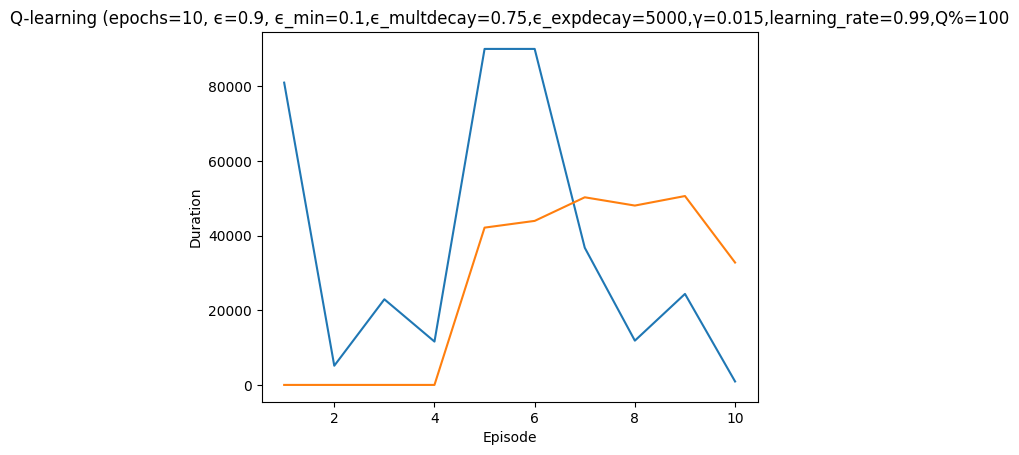

In [19]:
#ql
%matplotlib inline

random.seed(120394016)
def qlearning_run(gamma, gym_env):
    """Execute one run of the q-learning algorithm for the
    specified gamma value"""
    return learner.epsilon_greedy_search(
        gym_env,
        ep,
        a.QTabularLearner(ep, gamma=gamma, learning_rate=0.99, exploit_percentile=100),
        episode_count=training_episode_count,
        iteration_count=iteration_count,
        epsilon=0.90,
        render=False,
        epsilon_multdecay=0.75,  # 0.999,
        epsilon_exponential_decay=5000,
        epsilon_minimum=0.1,
        verbosity=Verbosity.Quiet,
        title="Q-learning"
    )

qlearning_results = [qlearning_run(gamma, cyberbattlechain_defender) for gamma in gamma_sweep]

qlearning_bestrun_10 = qlearning_results[0]

###### Exploiting DQL
Learning with: episode_count=10,iteration_count=90000,ϵ=0.0,ϵ_min=0.0, γ=0.015, lr=0.99, replaymemory=10000,
batch=256, target_update=5
  ## Episode: 1/10 'Exploiting DQL' ϵ=0.0000, γ=0.015, lr=0.99, replaymemory=10000,
batch=256, target_update=5


Episode 1|Iteration 2821|reward: 5476.0|last_reward_at: 2821|Elapsed Time: 0:00:19||


  Episode 1 ended at t=2821 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 1/42 (0.02)
    explore-remote: 1/178 (0.01)
    explore-connect: 0/178 (0.00)
    exploit-local: 2/223 (0.01)
    exploit-remote: 8/1528 (0.01)
    exploit-connect: 5/655 (0.01)
  exploit deflected to exploration: 400
  ## Episode: 2/10 'Exploiting DQL' ϵ=0.0000, γ=0.015, lr=0.99, replaymemory=10000,
batch=256, target_update=5


Episode 2|Iteration 7431|reward: 5476.0|last_reward_at: 7431|Elapsed Time: 0:00:49||


  Episode 2 ended at t=7431 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 1/101 (0.01)
    explore-remote: 4/440 (0.01)
    explore-connect: 0/465 (0.00)
    exploit-local: 2/660 (0.00)
    exploit-remote: 5/4139 (0.00)
    exploit-connect: 5/1609 (0.00)
  exploit deflected to exploration: 1011
  ## Episode: 3/10 'Exploiting DQL' ϵ=0.0000, γ=0.015, lr=0.99, replaymemory=10000,
batch=256, target_update=5


Episode 3|Iteration 30936|reward: 5412.0|last_reward_at: 30936|Elapsed Time: 0:03:51||


  Episode 3 ended at t=30936 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 1/501 (0.00)
    explore-remote: 1/2603 (0.00)
    explore-connect: 1/2598 (0.00)
    exploit-local: 2/3449 (0.00)
    exploit-remote: 7/15281 (0.00)
    exploit-connect: 3/6489 (0.00)
  exploit deflected to exploration: 5705
  ## Episode: 4/10 'Exploiting DQL' ϵ=0.0000, γ=0.015, lr=0.99, replaymemory=10000,
batch=256, target_update=5


Episode 4|Iteration 1611|reward: 5465.0|last_reward_at: 1611|Elapsed Time: 0:00:11||


  Episode 4 ended at t=1611 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 1/37 (0.03)
    explore-remote: 5/141 (0.03)
    explore-connect: 0/132 (0.00)
    exploit-local: 2/194 (0.01)
    exploit-remote: 3/721 (0.00)
    exploit-connect: 5/370 (0.01)
  exploit deflected to exploration: 316
  ## Episode: 5/10 'Exploiting DQL' ϵ=0.0000, γ=0.015, lr=0.99, replaymemory=10000,
batch=256, target_update=5


Episode 5|Iteration 90000|reward:  312.0|last_reward_at:  677|Elapsed Time: 0:12:46||


  Episode 5 stopped at t=90000 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 1/3944 (0.00)
    explore-remote: 2/12126 (0.00)
    explore-connect: 0/12290 (0.00)
    exploit-local: 1/12180 (0.00)
    exploit-remote: 6/46764 (0.00)
    exploit-connect: 3/2683 (0.00)
  exploit deflected to exploration: 28363
  ## Episode: 6/10 'Exploiting DQL' ϵ=0.0000, γ=0.015, lr=0.99, replaymemory=10000,
batch=256, target_update=5


Episode 6|Iteration 90000|reward:  312.0|last_reward_at:  458|Elapsed Time: 0:12:40||


  Episode 6 stopped at t=90000 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 1/2879 (0.00)
    explore-remote: 3/9840 (0.00)
    explore-connect: 1/10022 (0.00)
    exploit-local: 1/10214 (0.00)
    exploit-remote: 5/45111 (0.00)
    exploit-connect: 2/11921 (0.00)
  exploit deflected to exploration: 22746
  ## Episode: 7/10 'Exploiting DQL' ϵ=0.0000, γ=0.015, lr=0.99, replaymemory=10000,
batch=256, target_update=5


Episode 7|Iteration 90000|reward:  312.0|last_reward_at: 2869|Elapsed Time: 0:12:10||


  Episode 7 stopped at t=90000 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 1/2693 (0.00)
    explore-remote: 4/8373 (0.00)
    explore-connect: 1/8303 (0.00)
    exploit-local: 1/9412 (0.00)
    exploit-remote: 4/59212 (0.00)
    exploit-connect: 2/1994 (0.00)
  exploit deflected to exploration: 19375
  ## Episode: 8/10 'Exploiting DQL' ϵ=0.0000, γ=0.015, lr=0.99, replaymemory=10000,
batch=256, target_update=5


Episode 8|Iteration 90000|reward:  312.0|last_reward_at: 1240|Elapsed Time: 0:13:37||


  Episode 8 stopped at t=90000 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 1/2242 (0.00)
    explore-remote: 2/9474 (0.00)
    explore-connect: 2/9666 (0.00)
    exploit-local: 1/12159 (0.00)
    exploit-remote: 6/38796 (0.00)
    exploit-connect: 1/17650 (0.00)
  exploit deflected to exploration: 21387
  ## Episode: 9/10 'Exploiting DQL' ϵ=0.0000, γ=0.015, lr=0.99, replaymemory=10000,
batch=256, target_update=5


Episode 9|Iteration 50091|reward: 5312.0|last_reward_at: 50091|Elapsed Time: 0:06:35||


  Episode 9 ended at t=50091 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 1/831 (0.00)
    explore-remote: 4/4133 (0.00)
    explore-connect: 1/4224 (0.00)
    exploit-local: 1/5169 (0.00)
    exploit-remote: 4/27040 (0.00)
    exploit-connect: 3/8680 (0.00)
  exploit deflected to exploration: 9194
  ## Episode: 10/10 'Exploiting DQL' ϵ=0.0000, γ=0.015, lr=0.99, replaymemory=10000,
batch=256, target_update=5


Episode 10|Iteration 90000|reward:  312.0|last_reward_at: 2539|Elapsed Time: 0:13:57||


  Episode 10 stopped at t=90000 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 1/1905 (0.00)
    explore-remote: 3/9724 (0.00)
    explore-connect: 1/9546 (0.00)
    exploit-local: 1/11567 (0.00)
    exploit-remote: 5/39966 (0.00)
    exploit-connect: 2/17279 (0.00)
  exploit deflected to exploration: 21180
simulation ended


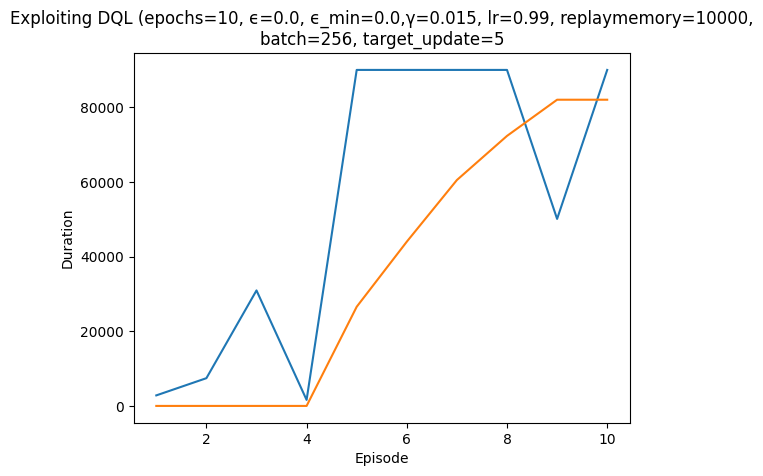

In [20]:
random.seed(120394016)
%matplotlib inline
dql_exploit_run = learner.epsilon_greedy_search(
    cyberbattlechain_defender,
    ep,
    learner=dqn_with_defender['learner'],
    episode_count=training_episode_count,
    iteration_count=iteration_count,
    epsilon=0.0,  
    render=False,
    # render_last_episode_rewards_to='images/chain10',
    verbosity=Verbosity.Quiet,
    title="Exploiting DQL"
)

###### Exploiting Q-matrix
Learning with: episode_count=10,iteration_count=90000,ϵ=0,ϵ_min=0.0, γ=0.0,learning_rate=0.0,Q%=100
  ## Episode: 1/10 'Exploiting Q-matrix' ϵ=0.0000, γ=0.0,learning_rate=0.0,Q%=100


Episode 1|Iteration 90000|reward:  117.0|last_reward_at:   29|Elapsed Time: 0:04:45||


  Episode 1 stopped at t=90000 loss={loss_string}
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 0/2 (0.00)
    explore-remote: 1/9 (0.10)
    explore-connect: 0/8 (0.00)
    exploit-local: 1/0 (1.00)
    exploit-remote: 4/3 (0.57)
    exploit-connect: 1/89971 (0.00)
  exploit deflected to exploration: 20
  ## Episode: 2/10 'Exploiting Q-matrix' ϵ=0.0000, γ=0.0,learning_rate=0.0,Q%=100


Episode 2|Iteration 90000|reward:  117.0|last_reward_at:   10|Elapsed Time: 0:04:48||


  Episode 2 stopped at t=90000 loss={loss_string}
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 0/0 (NaN)
    explore-remote: 1/0 (1.00)
    explore-connect: 0/2 (0.00)
    exploit-local: 1/0 (1.00)
    exploit-remote: 4/1 (0.80)
    exploit-connect: 1/89990 (0.00)
  exploit deflected to exploration: 3
  ## Episode: 3/10 'Exploiting Q-matrix' ϵ=0.0000, γ=0.0,learning_rate=0.0,Q%=100


Episode 3|Iteration 90000|reward:  312.0|last_reward_at: 22488|Elapsed Time: 0:05:03||


  Episode 3 stopped at t=90000 loss={loss_string}
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 0/42 (0.00)
    explore-remote: 4/187 (0.02)
    explore-connect: 1/149 (0.01)
    exploit-local: 2/0 (1.00)
    exploit-remote: 4/14 (0.22)
    exploit-connect: 2/89595 (0.00)
  exploit deflected to exploration: 383
  ## Episode: 4/10 'Exploiting Q-matrix' ϵ=0.0000, γ=0.0,learning_rate=0.0,Q%=100


Episode 4|Iteration 41461|reward: 5312.0|last_reward_at: 41461|Elapsed Time: 0:01:34||


  Episode 4 ended at t=41461 loss={loss_string}
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 0/84 (0.00)
    explore-remote: 4/466 (0.01)
    explore-connect: 1/473 (0.00)
    exploit-local: 2/0 (1.00)
    exploit-remote: 4/7 (0.36)
    exploit-connect: 3/40417 (0.00)
  exploit deflected to exploration: 1028
  ## Episode: 5/10 'Exploiting Q-matrix' ϵ=0.0000, γ=0.0,learning_rate=0.0,Q%=100


Episode 5|Iteration 90000|reward:  117.0|last_reward_at:   57|Elapsed Time: 0:04:48||


  Episode 5 stopped at t=90000 loss={loss_string}
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 0/2 (0.00)
    explore-remote: 1/22 (0.04)
    explore-connect: 0/21 (0.00)
    exploit-local: 1/0 (1.00)
    exploit-remote: 4/5 (0.44)
    exploit-connect: 1/89943 (0.00)
  exploit deflected to exploration: 46
  ## Episode: 6/10 'Exploiting Q-matrix' ϵ=0.0000, γ=0.0,learning_rate=0.0,Q%=100


Episode 6|Iteration 90000|reward:  123.0|last_reward_at:  167|Elapsed Time: 0:04:50||


  Episode 6 stopped at t=90000 loss={loss_string}
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 0/5 (0.00)
    explore-remote: 2/45 (0.04)
    explore-connect: 0/57 (0.00)
    exploit-local: 1/0 (1.00)
    exploit-remote: 4/4 (0.50)
    exploit-connect: 1/89881 (0.00)
  exploit deflected to exploration: 109
  ## Episode: 7/10 'Exploiting Q-matrix' ϵ=0.0000, γ=0.0,learning_rate=0.0,Q%=100


Episode 7|Iteration 90000|reward:  123.0|last_reward_at:   89|Elapsed Time: 0:04:48||


  Episode 7 stopped at t=90000 loss={loss_string}
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 0/7 (0.00)
    explore-remote: 2/30 (0.06)
    explore-connect: 0/28 (0.00)
    exploit-local: 1/0 (1.00)
    exploit-remote: 4/0 (1.00)
    exploit-connect: 1/89927 (0.00)
  exploit deflected to exploration: 67
  ## Episode: 8/10 'Exploiting Q-matrix' ϵ=0.0000, γ=0.0,learning_rate=0.0,Q%=100


Episode 8|Iteration 90000|reward:  123.0|last_reward_at:   87|Elapsed Time: 0:04:48||


  Episode 8 stopped at t=90000 loss={loss_string}
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 0/6 (0.00)
    explore-remote: 2/27 (0.07)
    explore-connect: 0/28 (0.00)
    exploit-local: 1/0 (1.00)
    exploit-remote: 4/2 (0.67)
    exploit-connect: 1/89929 (0.00)
  exploit deflected to exploration: 63
  ## Episode: 9/10 'Exploiting Q-matrix' ϵ=0.0000, γ=0.0,learning_rate=0.0,Q%=100


Episode 9|Iteration 90000|reward:  117.0|last_reward_at:  127|Elapsed Time: 0:04:50||


  Episode 9 stopped at t=90000 loss={loss_string}
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 0/8 (0.00)
    explore-remote: 1/43 (0.02)
    explore-connect: 0/49 (0.00)
    exploit-local: 1/0 (1.00)
    exploit-remote: 4/4 (0.50)
    exploit-connect: 1/89889 (0.00)
  exploit deflected to exploration: 101
  ## Episode: 10/10 'Exploiting Q-matrix' ϵ=0.0000, γ=0.0,learning_rate=0.0,Q%=100


Episode 10|Iteration 90000|reward:  198.0|last_reward_at: 6996|Elapsed Time: 0:04:59||


  Episode 10 stopped at t=90000 loss={loss_string}
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 0/140 (0.00)
    explore-remote: 4/599 (0.01)
    explore-connect: 0/575 (0.00)
    exploit-local: 1/0 (1.00)
    exploit-remote: 4/4 (0.50)
    exploit-connect: 2/88671 (0.00)
  exploit deflected to exploration: 1318
simulation ended


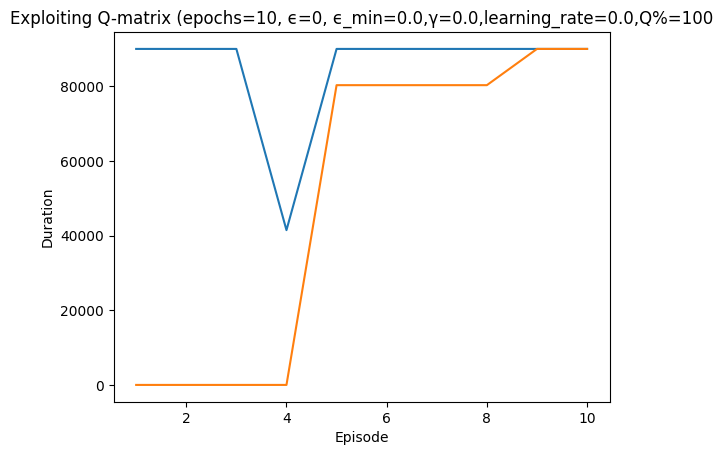

In [21]:
random.seed(120394016)
%matplotlib inline
ql_exploit_run = learner.epsilon_greedy_search(
    cyberbattlechain_defender,
    ep,
    learner=a.QTabularLearner(ep, trained=qlearning_bestrun_10['learner'],
                              gamma=0.0, learning_rate=0.0, exploit_percentile=100),
    episode_count=eval_episode_count,
    iteration_count=iteration_count,
    epsilon=0, 
    render=False,
    title="Exploiting Q-matrix",
    verbosity=Verbosity.Quiet
)

###### Random+CredLookup
Learning with: episode_count=10,iteration_count=90000,ϵ=0.9,ϵ_min=0.1, ϵ_multdecay=0.75,ϵ_expdecay=5000,
  ## Episode: 1/10 'Random+CredLookup' ϵ=0.9000, 


Episode 1|Iteration 90000|reward:  198.0|last_reward_at:  429|Elapsed Time: 0:04:14||


  Episode 1 stopped at t=90000 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 1/1952 (0.00)
    explore-remote: 8/12000 (0.00)
    explore-connect: 0/0 (NaN)
    exploit-local: 0/0 (NaN)
    exploit-remote: 0/0 (NaN)
    exploit-connect: 2/76037 (0.00)
  exploit deflected to exploration: 958
  ## Episode: 2/10 'Random+CredLookup' ϵ=0.1000, 


Episode 2|Iteration 90000|reward:  198.0|last_reward_at: 1173|Elapsed Time: 0:04:15||


  Episode 2 stopped at t=90000 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 1/1484 (0.00)
    explore-remote: 8/8652 (0.00)
    explore-connect: 0/0 (NaN)
    exploit-local: 0/0 (NaN)
    exploit-remote: 0/0 (NaN)
    exploit-connect: 2/79853 (0.00)
  exploit deflected to exploration: 1118
  ## Episode: 3/10 'Random+CredLookup' ϵ=0.1000, 


Episode 3|Iteration 90000|reward:  198.0|last_reward_at:  843|Elapsed Time: 0:04:15||


  Episode 3 stopped at t=90000 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 1/1355 (0.00)
    explore-remote: 8/8726 (0.00)
    explore-connect: 0/0 (NaN)
    exploit-local: 0/0 (NaN)
    exploit-remote: 0/0 (NaN)
    exploit-connect: 2/79908 (0.00)
  exploit deflected to exploration: 1072
  ## Episode: 4/10 'Random+CredLookup' ϵ=0.1000, 


Episode 4|Iteration 90000|reward:  198.0|last_reward_at:  201|Elapsed Time: 0:04:15||


  Episode 4 stopped at t=90000 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 1/1406 (0.00)
    explore-remote: 8/8703 (0.00)
    explore-connect: 0/0 (NaN)
    exploit-local: 0/0 (NaN)
    exploit-remote: 0/0 (NaN)
    exploit-connect: 2/79880 (0.00)
  exploit deflected to exploration: 1160
  ## Episode: 5/10 'Random+CredLookup' ϵ=0.1000, 


Episode 5|Iteration 90000|reward:  198.0|last_reward_at: 1156|Elapsed Time: 0:04:15||


  Episode 5 stopped at t=90000 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 1/1408 (0.00)
    explore-remote: 8/8881 (0.00)
    explore-connect: 0/0 (NaN)
    exploit-local: 0/0 (NaN)
    exploit-remote: 0/0 (NaN)
    exploit-connect: 2/79700 (0.00)
  exploit deflected to exploration: 1181
  ## Episode: 6/10 'Random+CredLookup' ϵ=0.1000, 


Episode 6|Iteration 90000|reward:  198.0|last_reward_at: 1568|Elapsed Time: 0:04:16||


  Episode 6 stopped at t=90000 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 1/1385 (0.00)
    explore-remote: 8/8668 (0.00)
    explore-connect: 0/0 (NaN)
    exploit-local: 0/0 (NaN)
    exploit-remote: 0/0 (NaN)
    exploit-connect: 2/79936 (0.00)
  exploit deflected to exploration: 1100
  ## Episode: 7/10 'Random+CredLookup' ϵ=0.1000, 


Episode 7|Iteration 90000|reward:  198.0|last_reward_at: 1916|Elapsed Time: 0:04:14||


  Episode 7 stopped at t=90000 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 1/1417 (0.00)
    explore-remote: 8/8708 (0.00)
    explore-connect: 0/0 (NaN)
    exploit-local: 0/0 (NaN)
    exploit-remote: 0/0 (NaN)
    exploit-connect: 2/79864 (0.00)
  exploit deflected to exploration: 1093
  ## Episode: 8/10 'Random+CredLookup' ϵ=0.1000, 


Episode 8|Iteration 90000|reward:  198.0|last_reward_at: 4167|Elapsed Time: 0:04:15||


  Episode 8 stopped at t=90000 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 1/1381 (0.00)
    explore-remote: 8/8559 (0.00)
    explore-connect: 0/0 (NaN)
    exploit-local: 0/0 (NaN)
    exploit-remote: 0/0 (NaN)
    exploit-connect: 2/80049 (0.00)
  exploit deflected to exploration: 1020
  ## Episode: 9/10 'Random+CredLookup' ϵ=0.1000, 


Episode 9|Iteration 90000|reward:  198.0|last_reward_at: 1023|Elapsed Time: 0:04:15||


  Episode 9 stopped at t=90000 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 1/1408 (0.00)
    explore-remote: 8/8863 (0.00)
    explore-connect: 0/0 (NaN)
    exploit-local: 0/0 (NaN)
    exploit-remote: 0/0 (NaN)
    exploit-connect: 2/79718 (0.00)
  exploit deflected to exploration: 1128
  ## Episode: 10/10 'Random+CredLookup' ϵ=0.1000, 


Episode 10|Iteration 90000|reward:  198.0|last_reward_at: 1528|Elapsed Time: 0:04:15||


  Episode 10 stopped at t=90000 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 1/1349 (0.00)
    explore-remote: 8/8733 (0.00)
    explore-connect: 0/0 (NaN)
    exploit-local: 0/0 (NaN)
    exploit-remote: 0/0 (NaN)
    exploit-connect: 2/79907 (0.00)
  exploit deflected to exploration: 1078
simulation ended


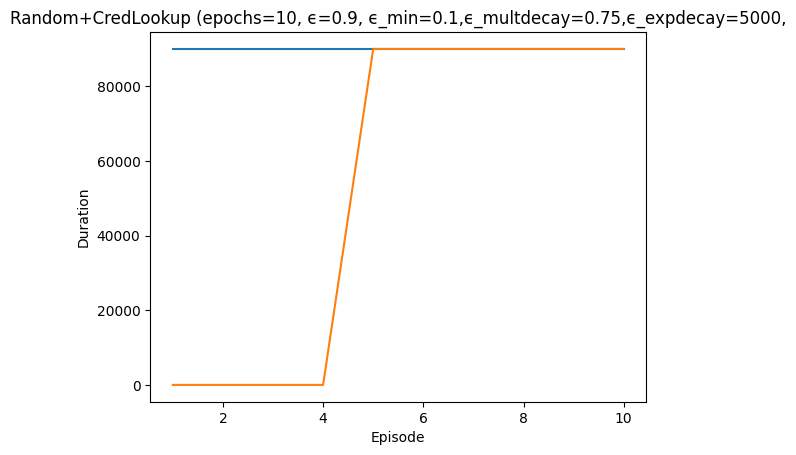

In [22]:
%matplotlib inline
random.seed(120394016)
credexplot = learner.epsilon_greedy_search(
    cyberbattlechain_defender,
    learner=rca.CredentialCacheExploiter(),
    environment_properties=ep,
    episode_count=training_episode_count,
    iteration_count=iteration_count,
    epsilon=0.90,
    render=False,
    epsilon_multdecay=0.75,  # 0.999,
    epsilon_exponential_decay=5000,
    epsilon_minimum=0.1,
    verbosity=Verbosity.Quiet,
    title="Random+CredLookup"
)

In [23]:
#takes 40 minutes to run so not using it
#%matplotlib inline
#randomlearning_results = learner.epsilon_greedy_search(
#    cyberbattlechain_defender,
 #   learner=rca.CredentialCacheExploiter(),
  #  environment_properties=ep,
   # episode_count=eval_episode_count,
    #iteration_count=iteration_count,
    #epsilon=1.0,  # purely random
    #render=False,
    #verbosity=Verbosity.Quiet,
    #title="Random search"
#)

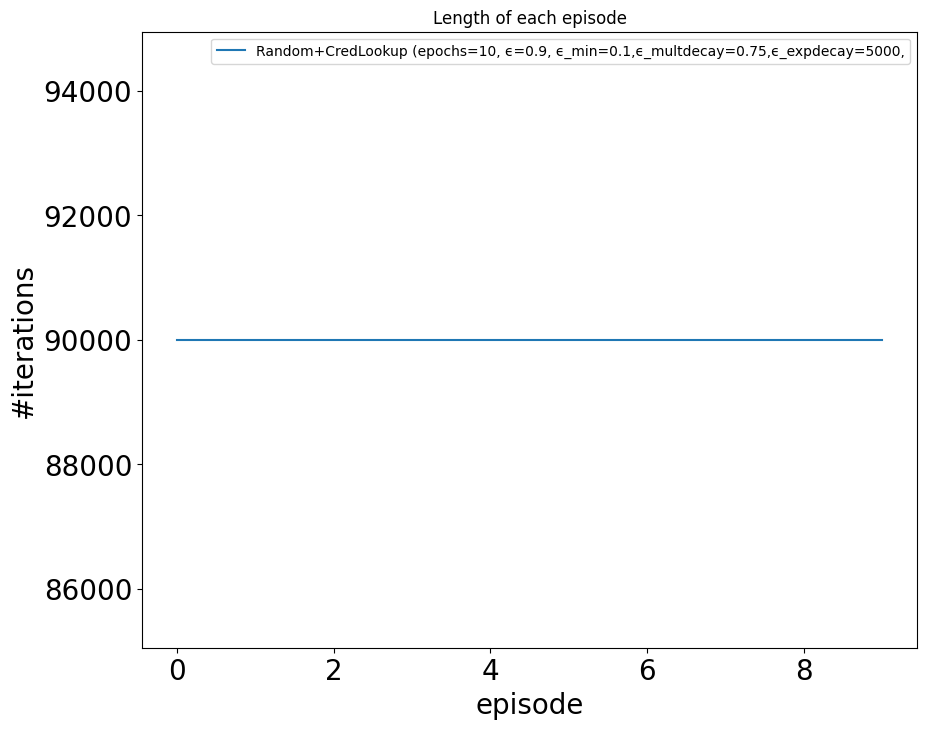

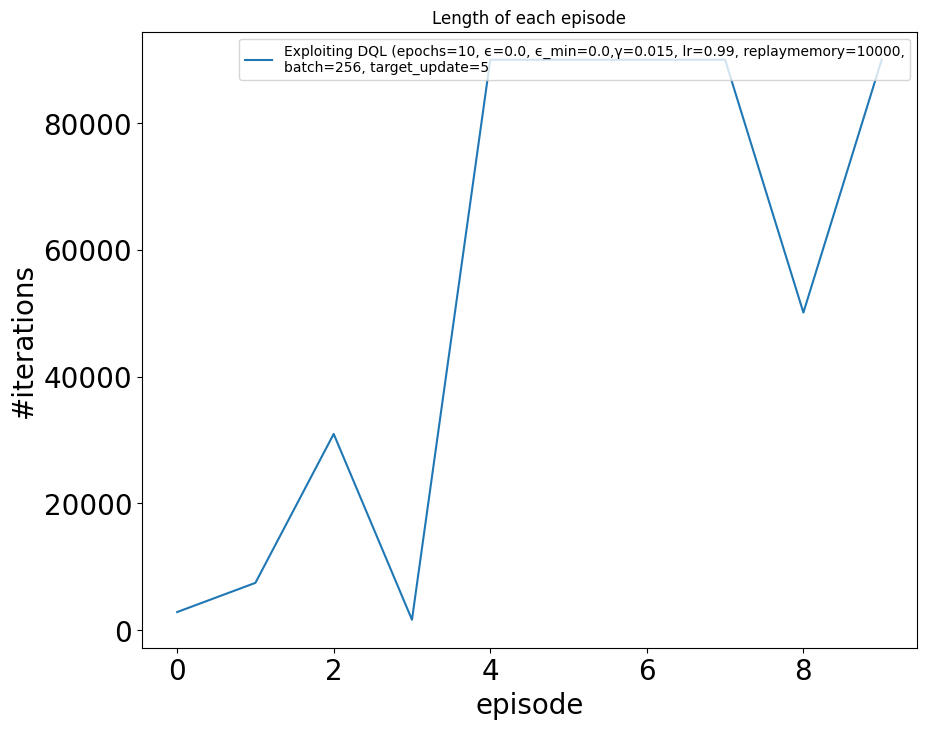

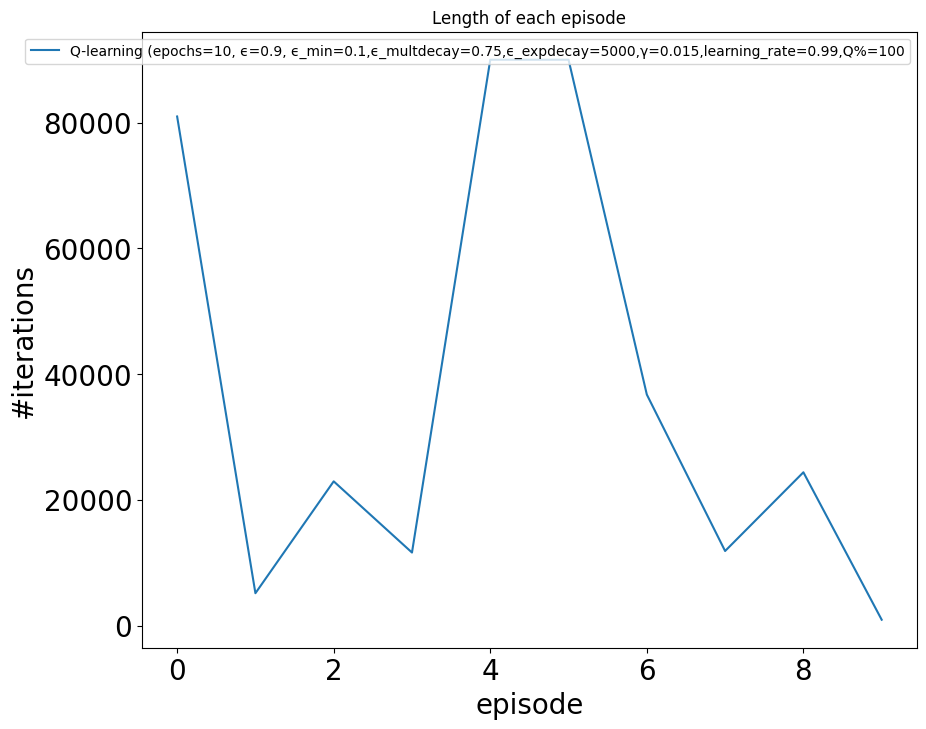

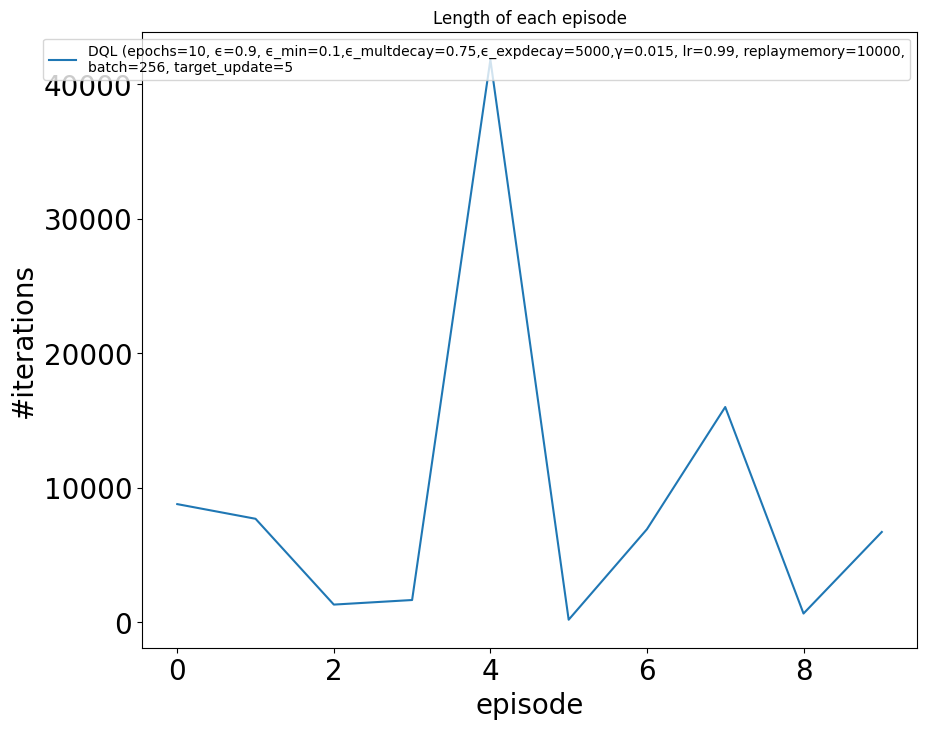

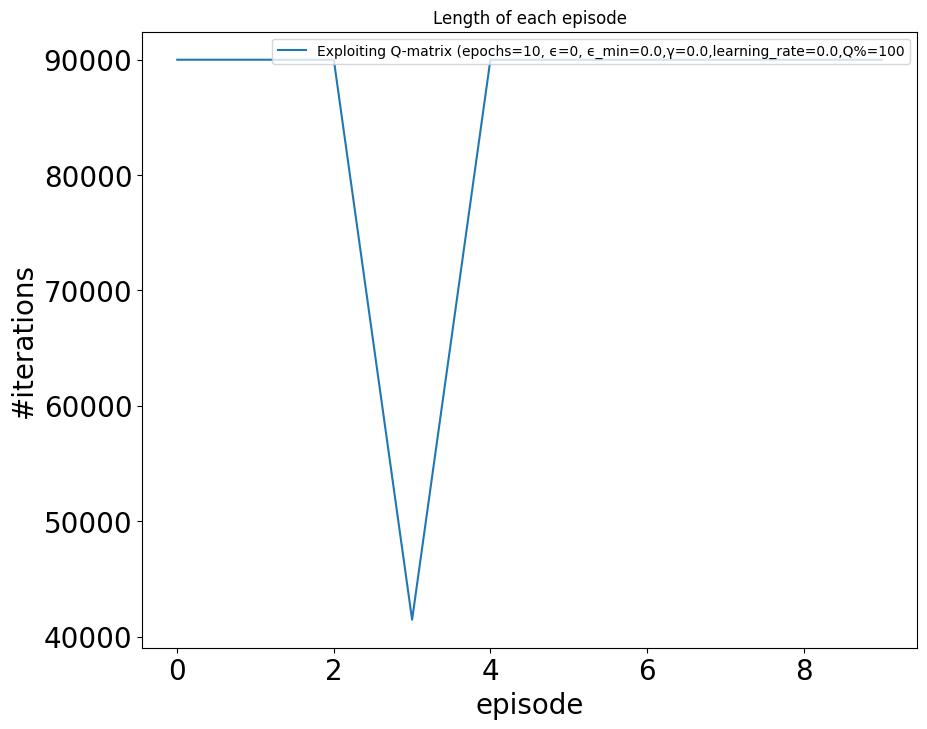

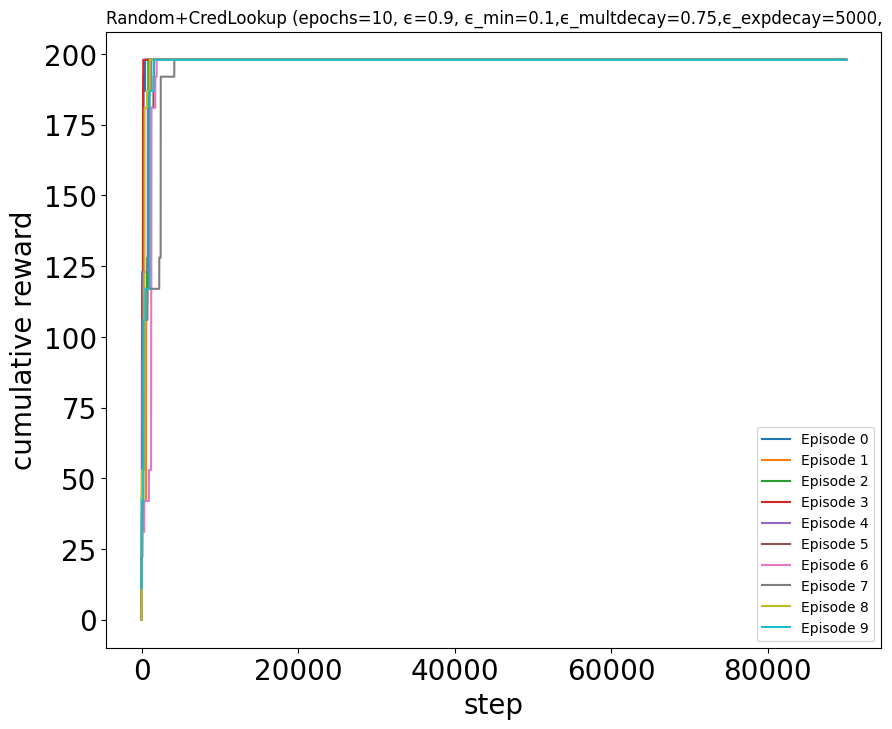

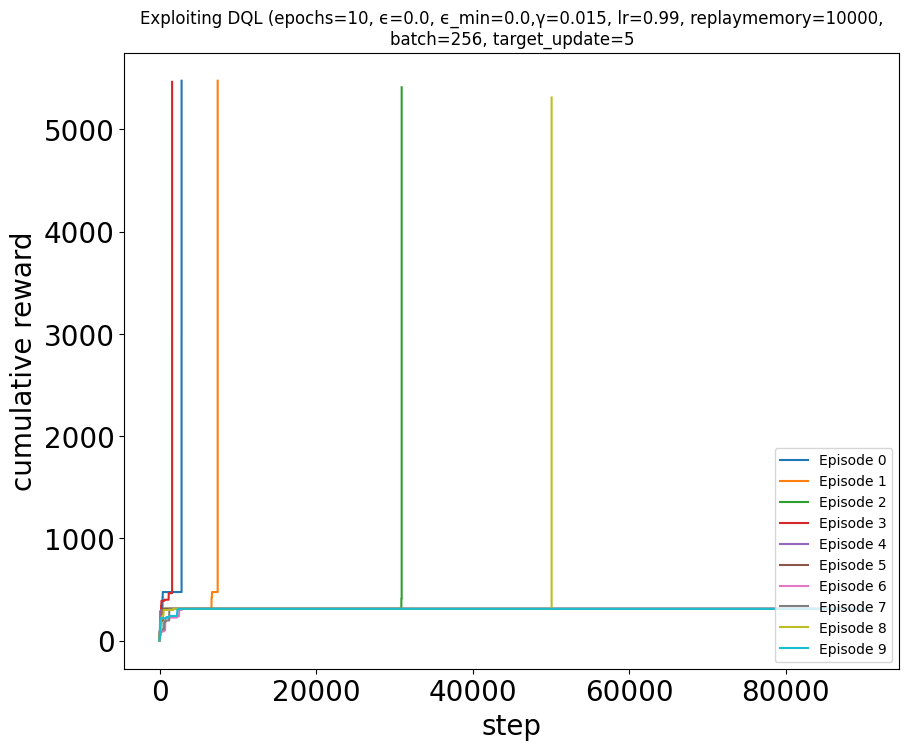

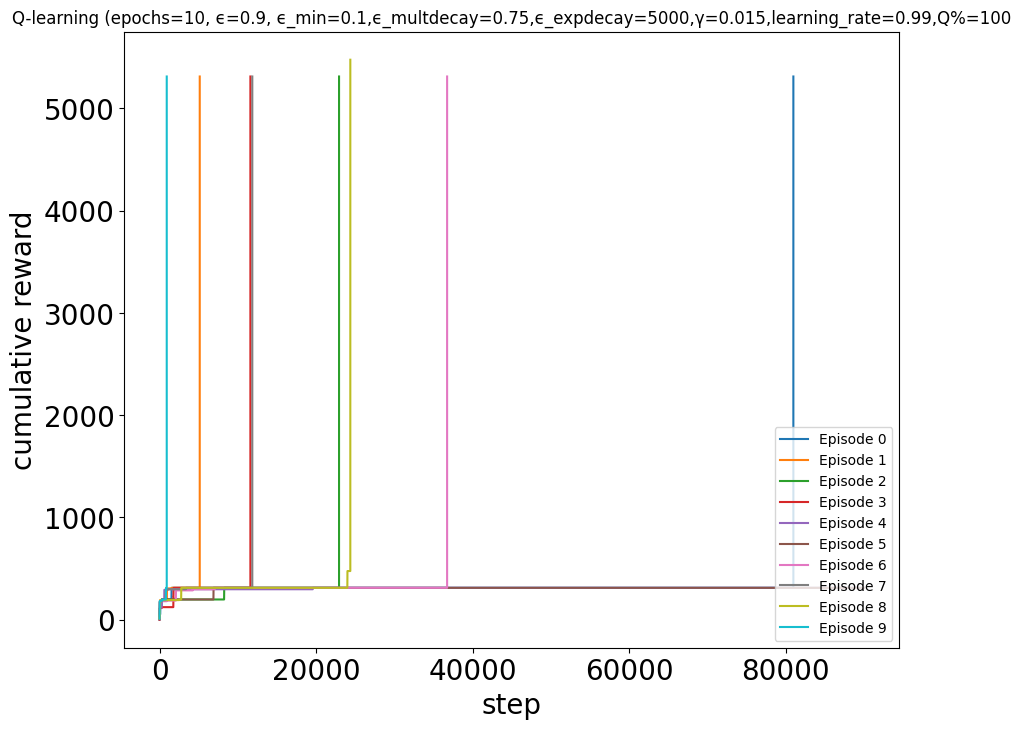

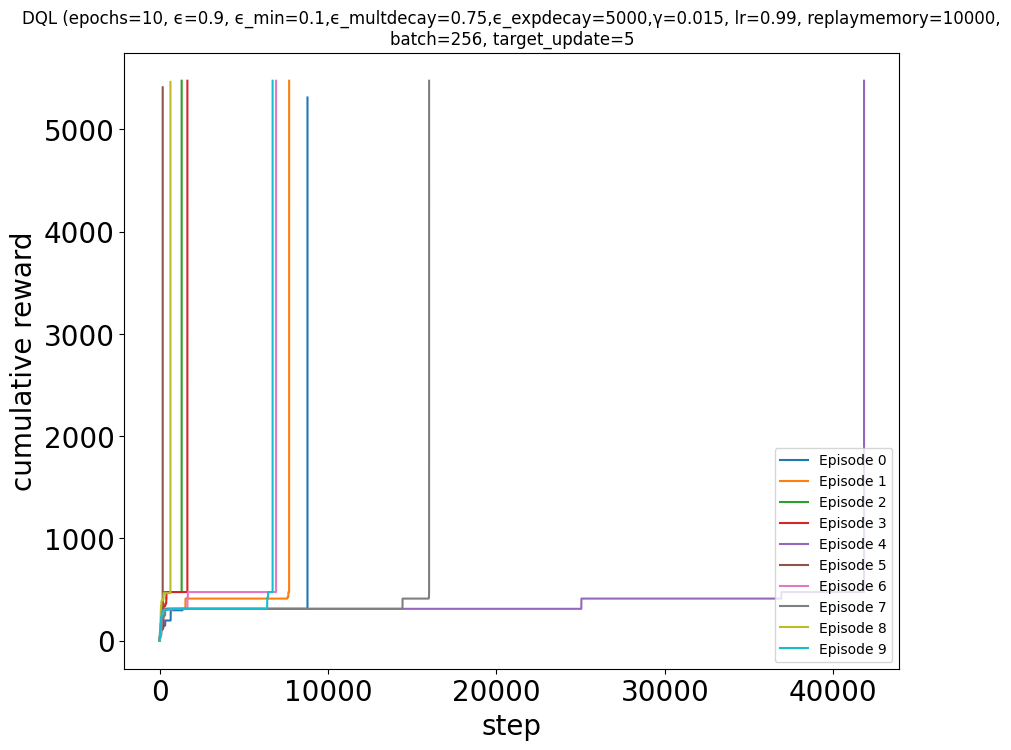

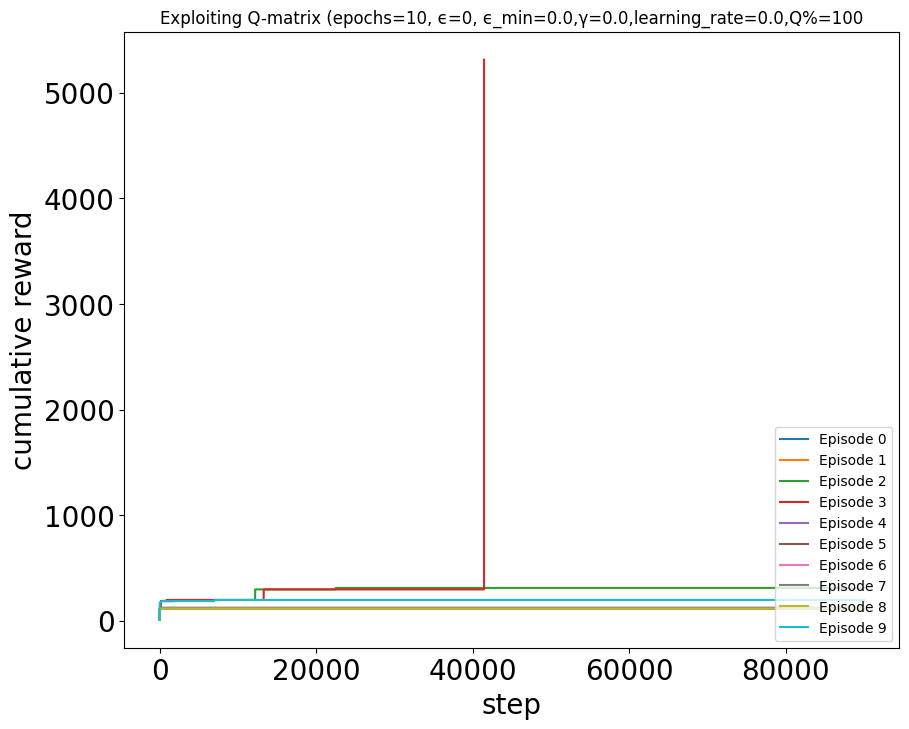

In [24]:
%matplotlib inline
random.seed(120394016)
p.plot_episodes_length([credexplot])
#p.plot_episodes_length([randomlearning_results])
p.plot_episodes_length([dql_exploit_run])
p.plot_episodes_length([qlearning_bestrun_10])
p.plot_episodes_length([dqn_with_defender])
p.plot_episodes_length([ql_exploit_run])
p.plot_all_episodes(credexplot)
#p.plot_all_episodes(randomlearning_results)
p.plot_all_episodes(dql_exploit_run)
p.plot_all_episodes(qlearning_bestrun_10)
p.plot_all_episodes(dqn_with_defender)
p.plot_all_episodes(ql_exploit_run)

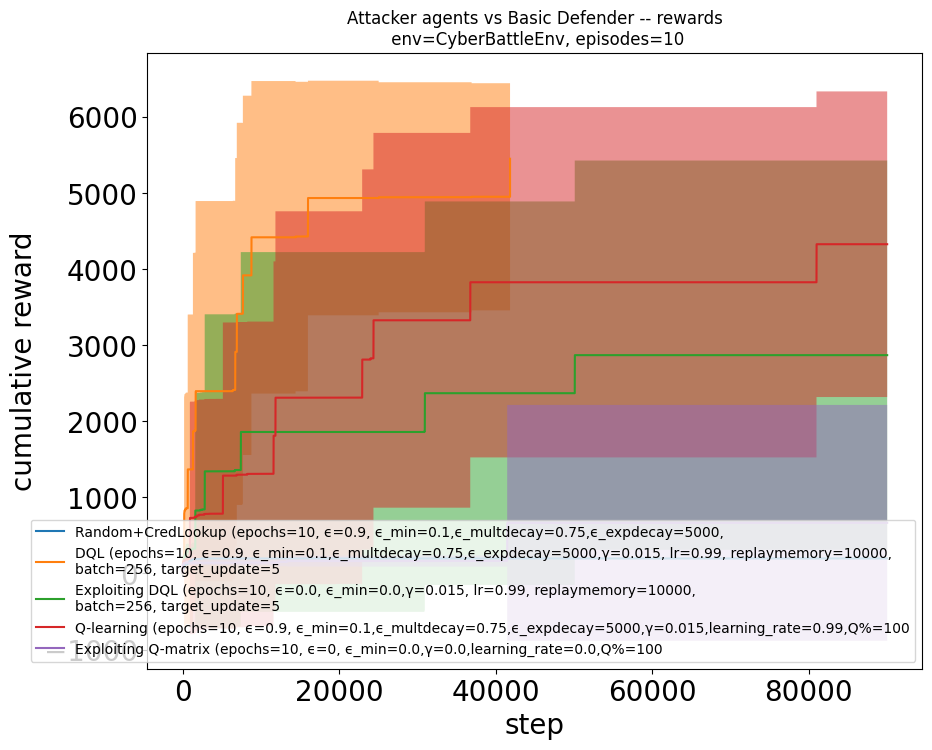

In [25]:
%matplotlib inline
random.seed(120394016)
# Plots
all_runs = [
    credexplot,
    dqn_with_defender,
    dql_exploit_run,
    qlearning_bestrun_10,
    ql_exploit_run
]
#randomlearning_results,
#    qlearning_bestrun_10,
 #   ql_exploit_run
p.plot_averaged_cummulative_rewards(
    all_runs=all_runs,
    title=f'Attacker agents vs Basic Defender -- rewards\n env={cyberbattlechain_defender.name}, episodes={training_episode_count}',
    show=False
)

In [40]:
from stable_baselines3.common.env_util import make_vec_env
import gym
from cyberbattle._env.cyberbattle_env import AttackerGoal, DefenderConstraint
from cyberbattle._env.defender import ScanAndReimageCompromisedMachines
from cyberbattle._env.flatten_wrapper import FlattenObservationWrapper, FlattenActionWrapper
from typing import cast
from cyberbattle._env.cyberbattle_env import CyberBattleEnv
from cyberbattle._env.cyberbattle_toyctf import CyberBattleToyCtf
import logging
import sys
from stable_baselines3.a2c.a2c import A2C
from stable_baselines3.ppo.ppo import PPO
from cyberbattle._env.flatten_wrapper import FlattenObservationWrapper, FlattenActionWrapper
import os

In [41]:
# %%
# !pip install stable-baselines3[extra]
env1 = FlattenActionWrapper(cyberbattlechain_defender)
ignore_fields = [
    # DummySpace
    '_credential_cache',
    '_discovered_nodes',
    '_explored_network',
]
env2 = FlattenObservationWrapper(cast(CyberBattleEnv, env1), ignore_fields=ignore_fields)

Filtering out field _credential_cache
Filtering out field _discovered_nodes
Filtering out field _explored_network
// MultiBinary flattened from [12, 12, 7, 10] -> 10080
// MultiBinary flattened from [12, 3] -> 36
// MultiBinary flattened from [12, 12, 8] -> 1152
// MultiBinary already flat: 1


In [42]:
print("Observation space:", env2.observation_space)


Observation space: Dict(action_mask_connect:MultiBinary(10080), action_mask_local_vulnerability:MultiBinary(36), action_mask_remote_vulnerability:MultiBinary(1152), credential_cache_length:Discrete(10), credential_cache_matrix_0:MultiDiscrete([12  7]), credential_cache_matrix_1:MultiDiscrete([12  7]), credential_cache_matrix_2:MultiDiscrete([12  7]), credential_cache_matrix_3:MultiDiscrete([12  7]), credential_cache_matrix_4:MultiDiscrete([12  7]), credential_cache_matrix_5:MultiDiscrete([12  7]), credential_cache_matrix_6:MultiDiscrete([12  7]), credential_cache_matrix_7:MultiDiscrete([12  7]), credential_cache_matrix_8:MultiDiscrete([12  7]), credential_cache_matrix_9:MultiDiscrete([12  7]), customer_data_found:MultiBinary(1), discovered_node_count:Discrete(12), discovered_nodes_properties_0:MultiDiscrete([3 3 3 3 3 3 3 3 3 3]), discovered_nodes_properties_1:MultiDiscrete([3 3 3 3 3 3 3 3 3 3]), discovered_nodes_properties_2:MultiDiscrete([3 3 3 3 3 3 3 3 3 3]), discovered_nodes_prop

In [ ]:

# %%
# MultiBinary
#  'action_mask',
#  'customer_data_found',
# MultiDiscrete space
#  'nodes_privilegelevel',
#  'leaked_credentials',
#  'credential_cache_matrix'
#  'discovered_nodes_properties',

ignore_fields = [
    # DummySpace
    '_credential_cache',
    '_discovered_nodes',
    '_explored_network',
]



In [ ]:
env2 = FlattenObservationWrapper(cast(CyberBattleEnv, env1), ignore_fields=ignore_fields)

In [ ]:
print("Observation space:", env2.observation_space)


In [36]:
# %%
model_a2c = A2C("MultiInputPolicy", env2).learn(10)
model_a2c.save('a2c_trained_toyctf')

In [33]:
# %%
# !pip install stable-baselines3[extra]

# %%
from typing import cast
from cyberbattle._env.cyberbattle_env import CyberBattleEnv
from cyberbattle._env.cyberbattle_toyctf import CyberBattleToyCtf
import logging
import sys
from stable_baselines3.a2c.a2c import A2C
from stable_baselines3.ppo.ppo import PPO
from cyberbattle._env.flatten_wrapper import FlattenObservationWrapper, FlattenActionWrapper
import os
os.environ["CUDA_LAUNCH_BLOCKING"] = '1'
retrain = ['a2c']


# %%

logging.basicConfig(stream=sys.stdout, level=logging.ERROR, format="%(levelname)s: %(message)s")

# %%
env = CyberBattleToyCtf(
    maximum_node_count=12,
    maximum_total_credentials=10,
    observation_padding=True,
    throws_on_invalid_actions=False,
)


# %%
env1 = FlattenActionWrapper(env)

# %%
# MultiBinary
#  'action_mask',
#  'customer_data_found',
# MultiDiscrete space
#  'nodes_privilegelevel',
#  'leaked_credentials',
#  'credential_cache_matrix'
#  'discovered_nodes_properties',

ignore_fields = [
    # DummySpace
    '_credential_cache',
    '_discovered_nodes',
    '_explored_network',
]
env2 = FlattenObservationWrapper(cast(CyberBattleEnv, env1), ignore_fields=ignore_fields)

Filtering out field _credential_cache
Filtering out field _discovered_nodes
Filtering out field _explored_network
// MultiBinary flattened from [12, 12, 7, 10] -> 10080
// MultiBinary flattened from [12, 3] -> 36
// MultiBinary flattened from [12, 12, 8] -> 1152
// MultiBinary already flat: 1


In [34]:
print("Observation space:", env2.observation_space)

Observation space: Dict(action_mask_connect:MultiBinary(10080), action_mask_local_vulnerability:MultiBinary(36), action_mask_remote_vulnerability:MultiBinary(1152), credential_cache_length:Discrete(10), credential_cache_matrix_0:MultiDiscrete([12  7]), credential_cache_matrix_1:MultiDiscrete([12  7]), credential_cache_matrix_2:MultiDiscrete([12  7]), credential_cache_matrix_3:MultiDiscrete([12  7]), credential_cache_matrix_4:MultiDiscrete([12  7]), credential_cache_matrix_5:MultiDiscrete([12  7]), credential_cache_matrix_6:MultiDiscrete([12  7]), credential_cache_matrix_7:MultiDiscrete([12  7]), credential_cache_matrix_8:MultiDiscrete([12  7]), credential_cache_matrix_9:MultiDiscrete([12  7]), customer_data_found:MultiBinary(1), discovered_node_count:Discrete(12), discovered_nodes_properties_0:MultiDiscrete([3 3 3 3 3 3 3 3 3 3]), discovered_nodes_properties_1:MultiDiscrete([3 3 3 3 3 3 3 3 3 3]), discovered_nodes_properties_2:MultiDiscrete([3 3 3 3 3 3 3 3 3 3]), discovered_nodes_prop